In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###PCA analysis and visualisation demo.

``Run time``: approximately ? minutes (workstation circa 2010)

``Memory requirement``: ~ ?GB


In [2]:
from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.simulator.plot import timeseries_interactive as timeseries_interactive

import tvb.analyzers.pca as pca

In [3]:
# if the demo data are not generated, this function will.
def generate_region_demo_data():
    """
    Generate 16 seconds of 2048Hz data at the region level, stochastic integration.
    
    ``Run time``: approximately 4 minutes (workstation circa 2010)
    
    ``Memory requirement``: < 1GB
    ``Storage requirement``: ~ 19MB
    
    .. moduleauthor:: Stuart A. Knock <stuart.knock@gmail.com>
    
    """
    
   
    ##----------------------------------------------------------------------------##
    ##-                      Perform the simulation                              -##
    ##----------------------------------------------------------------------------##
    
    LOG.info("Configuring...")
    
    #Initialise a Model, Coupling, and Connectivity.
    pars = {'a': 1.05,
            'b': -1.,
            'c': 0.0,
            'd': 0.1,
            'e': 0.0,
            'f': 1 / 3.,
            'g': 1.0,
            'alpha': 1.0,
            'beta': 0.2,
            'tau': 1.25,
            'gamma': -1.0}
    
    oscillator = models.Generic2dOscillator(**pars)
    
    white_matter = connectivity.Connectivity(load_default=True)
    white_matter.speed = numpy.array([4.0])
    white_matter_coupling = coupling.Linear(a=0.033)
    
    #Initialise an Integrator
    hiss = noise.Additive(nsig=numpy.array([2 ** -10, ]))
    heunint = integrators.HeunStochastic(dt=0.06103515625, noise=hiss) 
    
    #Initialise a Monitor with period in physical time
    what_to_watch = monitors.TemporalAverage(period=0.48828125)     # 2048Hz => period=1000.0/2048.0
    
    #Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
    sim = simulator.Simulator(model=oscillator, connectivity=white_matter,
                              coupling=white_matter_coupling,
                              integrator=heunint, monitors=what_to_watch)
    
    sim.configure()
    
    #Perform the simulation
    tavg_data = []
    tavg_time = []
    LOG.info("Starting simulation...")
    for tavg in sim(simulation_length=16000):
        if tavg is not None:
            tavg_time.append(tavg[0][0])    # TODO:The first [0] is a hack for single monitor
            tavg_data.append(tavg[0][1])    # TODO:The first [0] is a hack for single monitor
    
    LOG.info("Finished simulation.")
    
    
    ##----------------------------------------------------------------------------##
    ##-                     Save the data to a file                              -##
    ##----------------------------------------------------------------------------##
    
    #Make the list a numpy.array.
    LOG.info("Converting result to array...")
    TAVG = numpy.array(tavg_data)
    
    #Save it
    FILE_NAME = "demo_data_region_16s_2048Hz.npy"
    LOG.info("Saving array to %s..." % FILE_NAME)
    numpy.save(FILE_NAME, TAVG)
    
    LOG.info("Done.")

In [4]:
#Load the demo region timeseries dataset 
try:
    data = numpy.load("demo_data_region_16s_2048Hz.npy")
except IOError:
    LOG.error("Can't load demo data. Run demos/generate_region_demo_data.py")
    generate_region_demo_data()
    data = numpy.load("demo_data_region_16s_2048Hz.npy")


In [5]:
period = 0.00048828125  # s

In [6]:
#Put the data into a TimeSeriesRegion datatype
white_matter = connectivity.Connectivity(load_default=True)
tsr = TimeSeriesRegion(connectivity=white_matter,
                       data=data,
                       sample_period=period)
tsr.configure()

In [7]:
#Create and run the analyser
pca_analyser = pca.PCA(time_series=tsr)
pca_data = pca_analyser.evaluate()

In [8]:
#Generate derived data, such as, component time series, etc.
pca_data.configure()


In [9]:
#Put the data into a TimeSeriesSurface datatype
component_tsr = TimeSeriesRegion(connectivity=white_matter,
                                 data=pca_data.component_time_series,
                                 sample_period=period)
component_tsr.configure()


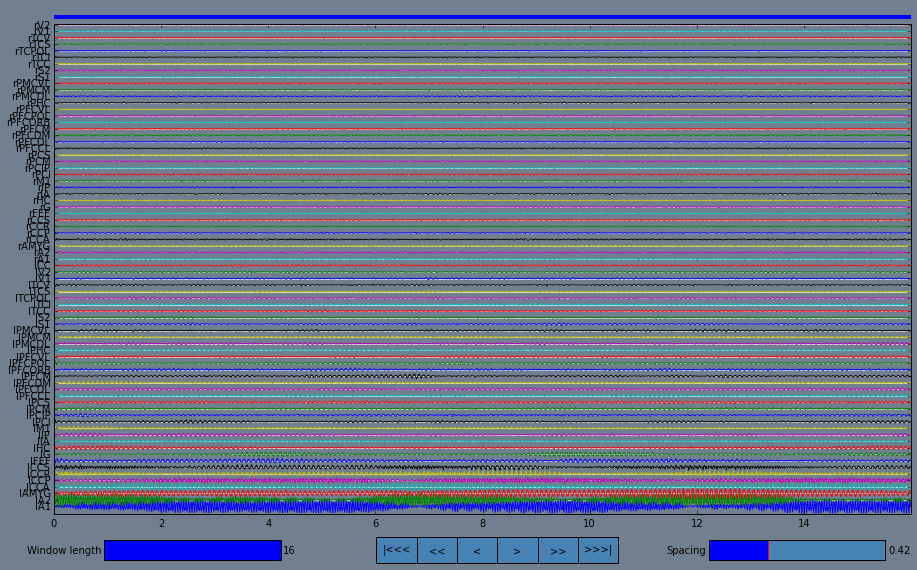

In [10]:
#Prutty puctures...
tsi = timeseries_interactive.TimeSeriesInteractive(time_series=component_tsr)
tsi.configure()
tsi.show()


In [11]:
#if IMPORTED_MAYAVI:
#    xmas_balls(tsr.connectivity, pca_data.weights[:, 0, 0, 0], edge_data=True)